In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import curve_fit

In [3]:
#constants
A = 17.27
B = 35.86
G = 0.0065
M = 0.018 #kg/mol
R = 8.31 #universal gas constant
d1 = 1.33
d2 = 0.068
density = 998 #kg/m^3
alpha = 611*M/R
a = 0.41
u = 0.35
def Pvapor(T):
    return 611*np.exp(A*(T-273.15)/(T - B)) #temperature in kelvin, pressure in pascal
def Wm(z,T_0):
    return M*Pvapor(T_0-G*z)/R/(T_0 - G*z) #gives density in kg/m^3
def getlenght(Tvalue,RHvalue):
    T = np.atleast_1d(Tvalue)
    RH = np.atleast_1d(RHvalue)
    Masses = np.zeros((len(RH),len(T)))
    for i in range(len(T)):
        integral = alpha*quad(Wm, a = 0, b = 10000, args=(T[i]), limit= 500)[0] #this is an overestimation since below 0 degrees you have to use ice formation
        Mass = RH*integral
        Masses[:,i] = Mass
    lengths = (Masses)/density *100 #lenght in cm
    return lengths
def emissivity(Tvalue,RHvalue):
    T = np.atleast_1d(Tvalue)
    RH = np.atleast_1d(RHvalue)
    emissivities = np.zeros((len(RH),len(T)))
    for i in range(len(T)):
        e = 1- 0.83*a*np.exp(-u*RH*d1*np.exp(d2*(T[i]- 13 - 273.15)))
        emissivities[:,i] = e
    return emissivities #-13 is because water in atmosphere is colder on average and -273.15 to convert to celcius

In [4]:
print(Pvapor(273.15+22)/Pvapor(273.15+40))

0.3584573729900984


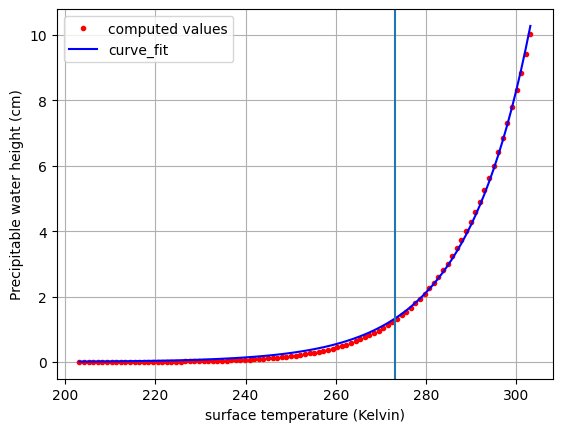

1.3302990586053998 0.06814914081412592


In [5]:
T = np.linspace(203.15, 303.15,99)
def exp(x,a,b):
    return a*np.exp(b*(x-273.15))
popt, pcov = curve_fit(exp, T, getlenght(T,1)[0])
plt.figure()
plt.plot(T,getlenght(T,1)[0], 'r.', label = 'computed values')
plt.plot(T,exp(T, *popt), 'b-', label = 'curve_fit')
plt.grid()
plt.axvline(273.15)
plt.xlabel('surface temperature (Kelvin)')
plt.ylabel('Precipitable water height (cm)')
plt.legend()
plt.show()
print(*popt)

Literature says: 0:72 + 0.009(pw-2) 

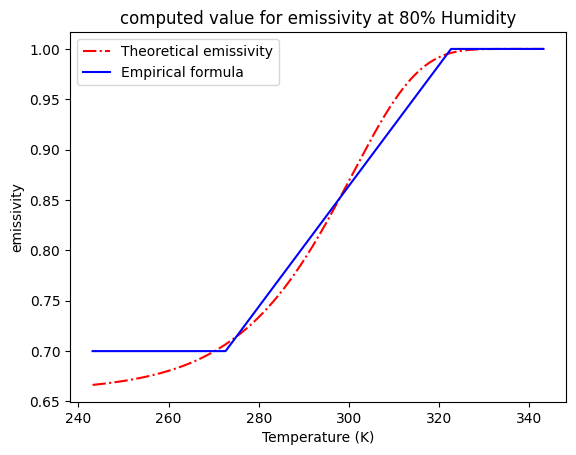

In [6]:
T = np.linspace(243.15,343.15,1000)
RH = 0.8


def e_literature(T,RH): 
    Tdew = T-(100-100*RH)/5
    emis = 0.727 + 0.0060*(Tdew - 273.15)
    emis = np.where(emis<0.7, 0.7, emis)
    emis = np.where(emis>1, 1, emis)
    return emis

plt.figure()
plt.plot(T, emissivity(T,RH)[0], 'r-.', label = 'Theoretical emissivity')
plt.plot(T, e_literature(T,RH), 'b-', label = 'Empirical formula')
plt.title('computed value for emissivity at 80% Humidity')
plt.xlabel('Temperature (K)')
plt.ylabel('emissivity')
plt.legend()
plt.show()

In [7]:
print(np.cov(emissivity(T,RH),e_literature(T,RH)))

[[0.01750499 0.01605706]
 [0.01605706 0.01484045]]


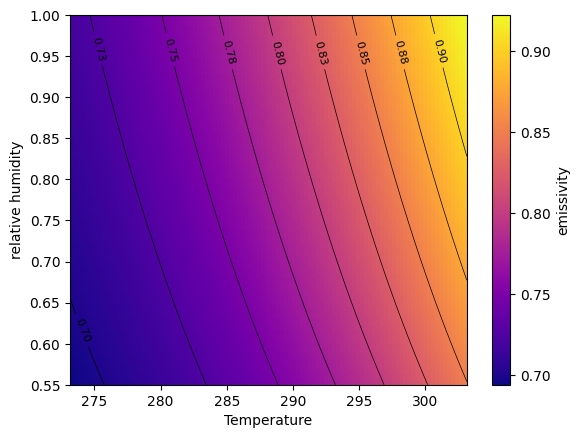

In [9]:
T = np.linspace(273.15,303.15,100)
RH = np.linspace(0.55,1,100)
emissivities = emissivity(T,RH)
plt.figure()
plt.imshow(emissivities,cmap= 'plasma', origin = 'lower', aspect = 'auto', extent = [T[0],T[-1], RH[0], RH[-1]])
plt.colorbar(label = 'emissivity')
plt.ylabel('relative humidity')
plt.xlabel('Temperature')

contours = plt.contour(
    T, RH, emissivities, levels=10, colors="k", linewidths=0.5
)
plt.clabel(contours, inline=True, fontsize=8, fmt="%.2f")
plt.show()
